# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217393

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                       net.regularized_loss, 
                                                       ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})
                        train_batch()

                        count = 10
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -=1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, test_loss, accuracy))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_vae_loss_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})
                        Train.best_acc = accuracy

                        if(not np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, time.perf_counter() - start_time))})



In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [30]
    lrs = [1e-2, 1e-2]
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:30 hidden layers:2 features count:4
Step 1 | Training Loss: 0.000617 | Test Loss: 0.005646 | Test Accuracy: 0.791031
Step 2 | Training Loss: 0.000093 | Test Loss: 0.003425 | Test Accuracy: 0.813121
Step 3 | High Training Loss: 172337.109375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-2
Step 3 | High Training Loss: 48239.164062 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-2
Step 3 | High Training Loss: 48247.074219 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-2
Step 3 | High Training Loss: 48234.875000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-2
Step 3 | High Training Loss: 48235.175781 .

Step 16 | Training Loss: 0.000770 | Test Loss: 0.007498 | Test Accuracy: 0.759049
Step 17 | High Training Loss: 221117.296875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-6
Step 17 | Training Loss: 0.000407 | Test Loss: 0.010141 | Test Accuracy: 0.806911
Step 18 | High Training Loss: 1031685184.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-6
Step 18 | Training Loss: 0.002181 | Test Loss: 0.013543 | Test Accuracy: 0.801233
Step 19 | Training Loss: 0.000926 | Test Loss: 0.028239 | Test Accuracy: 0.746052
Step 20 | High Training Loss: 76153318831858647040.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-6
Step 20 | Training Loss: 0.000811 | Test Loss: 0.006824 | Test Accuracy: 0.834191
Step 21 | Training Loss

Step 3 | High Training Loss: 2816767.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-2
Step 3 | High Training Loss: 2816768.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-2
Step 3 | High Training Loss: 2816768.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-2
Step 3 | High Training Loss: 2816767.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-2
Step 3 | High Training Loss: 2816774.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-2
Step 3 | High Training Loss: 2816791.500000 ... Restoring Net
INFO:tensorflow:Restori

Step 6 | High Training Loss: 240551.046875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-5
Step 6 | High Training Loss: 240551.781250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-5
Step 6 | High Training Loss: 240550.656250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-5
Step 6 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-5
Step 6 | High Training Loss: 241945.718750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_30_features count_2/model-5
Step 6 | High Training Loss: 241946.234375 ... Restoring Net
INFO:tensorflow:Restoring parameters fr

Step 30 | Training Loss: 0.000089 | Test Loss: 0.011049 | Test Accuracy: 0.779099
Current Layer Attributes - epochs:30 hidden layers:2 features count:32
Step 1 | Training Loss: 0.000642 | Test Loss: 0.005734 | Test Accuracy: 0.761400
Step 2 | Training Loss: 0.000846 | Test Loss: 0.006277 | Test Accuracy: 0.768763
Step 3 | Training Loss: 0.000214 | Test Loss: 0.006594 | Test Accuracy: 0.764239
Step 4 | Training Loss: 0.000704 | Test Loss: 0.004734 | Test Accuracy: 0.758916
Step 5 | Training Loss: 0.000765 | Test Loss: 0.005374 | Test Accuracy: 0.753149
Step 6 | Training Loss: 0.000390 | Test Loss: 0.005912 | Test Accuracy: 0.746629
Step 7 | Training Loss: 0.000138 | Test Loss: 0.006047 | Test Accuracy: 0.706130
Step 8 | Training Loss: 0.000052 | Test Loss: 0.006075 | Test Accuracy: 0.704578
Step 9 | Training Loss: 0.000090 | Test Loss: 0.005493 | Test Accuracy: 0.769917
Step 10 | Training Loss: 0.000055 | Test Loss: 0.005571 | Test Accuracy: 0.762065
Step 11 | Training Loss: 0.000212 | 

Step 4 | Training Loss: 0.000453 | Test Loss: 0.002711 | Test Accuracy: 0.813565
Step 5 | Training Loss: 0.000138 | Test Loss: 0.002565 | Test Accuracy: 0.817069
Step 6 | Training Loss: 0.000752 | Test Loss: 0.003243 | Test Accuracy: 0.768098
Step 7 | Training Loss: 0.000040 | Test Loss: 0.002533 | Test Accuracy: 0.825231
Step 8 | Training Loss: 0.000160 | Test Loss: 0.002846 | Test Accuracy: 0.808907
Step 9 | Training Loss: 0.000023 | Test Loss: 0.002285 | Test Accuracy: 0.805270
Step 10 | Training Loss: 0.000390 | Test Loss: 0.003194 | Test Accuracy: 0.826384
Step 11 | Training Loss: 0.000093 | Test Loss: 0.003699 | Test Accuracy: 0.781893
Step 12 | Training Loss: 0.000302 | Test Loss: 0.002709 | Test Accuracy: 0.779986
Step 13 | Training Loss: 0.000024 | Test Loss: 0.003272 | Test Accuracy: 0.806024
Step 14 | Training Loss: 0.000440 | Test Loss: 0.002977 | Test Accuracy: 0.798838
Step 15 | Training Loss: 0.000023 | Test Loss: 0.002579 | Test Accuracy: 0.801366
Step 16 | Training Los

Step 11 | Training Loss: 0.000752 | Test Loss: 0.010689 | Test Accuracy: 0.671620
Step 12 | Training Loss: 0.000302 | Test Loss: 0.012836 | Test Accuracy: 0.667805
Step 13 | Training Loss: 0.000136 | Test Loss: 0.011955 | Test Accuracy: 0.667406
Step 14 | Training Loss: 0.000049 | Test Loss: 0.010072 | Test Accuracy: 0.673084
Step 15 | Training Loss: 0.000519 | Test Loss: 0.011947 | Test Accuracy: 0.640924
Step 16 | Training Loss: 0.000122 | Test Loss: 0.011866 | Test Accuracy: 0.667628
Step 17 | Training Loss: 0.000133 | Test Loss: 0.018174 | Test Accuracy: 0.662305
Step 18 | Training Loss: 0.000174 | Test Loss: 0.009846 | Test Accuracy: 0.673927
Step 19 | Training Loss: 0.000216 | Test Loss: 0.015422 | Test Accuracy: 0.607878
Step 20 | Training Loss: 0.000344 | Test Loss: 0.015430 | Test Accuracy: 0.604196
Step 21 | Training Loss: 0.000022 | Test Loss: 0.013614 | Test Accuracy: 0.604729
Step 22 | Training Loss: 0.000563 | Test Loss: 0.020944 | Test Accuracy: 0.603132
Step 23 | Traini

Step 19 | Training Loss: 0.000315 | Test Loss: 0.001135 | Test Accuracy: 0.768187
Step 20 | Training Loss: 0.000041 | Test Loss: 0.001110 | Test Accuracy: 0.773953
Step 21 | Training Loss: 0.000389 | Test Loss: 0.001055 | Test Accuracy: 0.569242
Step 22 | Training Loss: 0.000190 | Test Loss: 0.001436 | Test Accuracy: 0.783579
Step 23 | Training Loss: 0.000111 | Test Loss: 0.001661 | Test Accuracy: 0.569242
Step 24 | Training Loss: 0.000468 | Test Loss: 0.001651 | Test Accuracy: 0.780119
Step 25 | Training Loss: 0.000037 | Test Loss: 0.001703 | Test Accuracy: 0.779454
Step 26 | Training Loss: 0.000797 | Test Loss: 0.001189 | Test Accuracy: 0.569242
Step 27 | Training Loss: 0.000856 | Test Loss: 0.001503 | Test Accuracy: 0.694996
Step 28 | Training Loss: 0.000734 | Test Loss: 0.001895 | Test Accuracy: 0.569242
Step 29 | Training Loss: 0.000174 | Test Loss: 0.001235 | Test Accuracy: 0.713715
Step 30 | Training Loss: 0.000258 | Test Loss: 0.001836 | Test Accuracy: 0.704312
Current Layer At

Step 28 | Training Loss: 0.006350 | Test Loss: 0.009774 | Test Accuracy: 0.430758
Step 29 | Training Loss: 0.006483 | Test Loss: 0.009748 | Test Accuracy: 0.569287
Step 30 | Training Loss: 0.006977 | Test Loss: 0.009787 | Test Accuracy: 0.430758
Step 1 | Training Loss: 0.006580 | Test Loss: 0.009828 | Test Accuracy: 0.430758
Step 2 | Training Loss: 0.006909 | Test Loss: 0.009869 | Test Accuracy: 0.430758
Step 3 | Training Loss: 0.007634 | Test Loss: 0.009480 | Test Accuracy: 0.430758
Step 4 | Training Loss: 0.007155 | Test Loss: 0.009370 | Test Accuracy: 0.430758
Step 5 | Training Loss: 0.006753 | Test Loss: 0.009250 | Test Accuracy: 0.430758
Step 6 | Training Loss: 0.006717 | Test Loss: 0.009330 | Test Accuracy: 0.569242
Step 7 | Training Loss: 0.007493 | Test Loss: 0.009450 | Test Accuracy: 0.430758
Step 8 | Training Loss: 0.007014 | Test Loss: 0.009456 | Test Accuracy: 0.430758
Step 9 | Training Loss: 0.007561 | Test Loss: 0.009180 | Test Accuracy: 0.569242
Step 10 | Training Loss: 

Step 7 | Training Loss: 0.000071 | Test Loss: 0.004111 | Test Accuracy: 0.781938
Step 8 | Training Loss: 0.000523 | Test Loss: 0.002179 | Test Accuracy: 0.827626
Step 9 | Training Loss: 0.000776 | Test Loss: 0.005148 | Test Accuracy: 0.674725
Step 10 | Training Loss: 0.000418 | Test Loss: 0.004752 | Test Accuracy: 0.677919
Step 11 | Training Loss: 0.000101 | Test Loss: 0.004605 | Test Accuracy: 0.673217
Step 12 | Training Loss: 0.000004 | Test Loss: 0.003707 | Test Accuracy: 0.669668
Step 13 | Training Loss: 0.000194 | Test Loss: 0.003857 | Test Accuracy: 0.672951
Step 14 | Training Loss: 0.000017 | Test Loss: 0.004829 | Test Accuracy: 0.672152
Step 15 | Training Loss: 0.000038 | Test Loss: 0.003236 | Test Accuracy: 0.569242
Step 16 | Training Loss: 0.000256 | Test Loss: 0.004773 | Test Accuracy: 0.662127
Step 17 | Training Loss: 0.001228 | Test Loss: 0.005983 | Test Accuracy: 0.623980
Step 18 | Training Loss: 0.000108 | Test Loss: 0.006608 | Test Accuracy: 0.592441
Step 19 | Training 

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)
    

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,time_taken
7,60,32,4,0.899190,0.894828,277.087312
5,60,8,4,0.784648,0.888618,326.445902
2,60,16,2,0.906255,0.861781,22.907380
8,60,4,6,0.872837,0.851757,78.289377
1,60,8,2,0.943959,0.849849,22.652336
4,60,4,4,0.816876,0.848031,333.715173
11,60,32,6,0.901969,0.845413,9.349152
9,60,8,6,0.856247,0.838893,44.365170
10,60,16,6,0.902762,0.832638,306.418287
6,60,16,4,0.911811,0.826207,12.959080


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_scores.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.925  0.075]
 [ 0.145  0.855]]


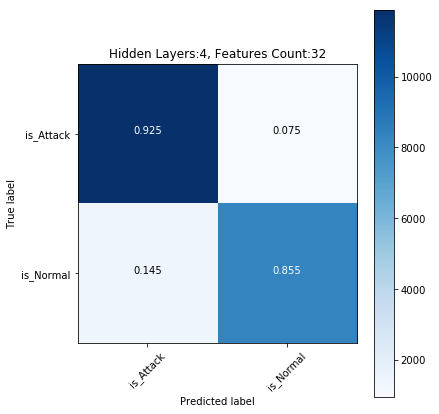

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)